In [ ]:
# default_exp learners

# Learners

> Learners to train models.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#export

from fastai.vision.all import *
from fastprogress.fastprogress import progress_bar
from fastai_object_detection.callbacks import *
from fastai_object_detection.models.all import *
from fastai_object_detection.metrics import *

## Splitters

Splitters for spliting the model into head and body for freezing and differential learning rates.

In [ ]:
#export

def no_split(m):
    "No split of params for models"
    return L(m).map(params)

def rcnn_split(m):
    "Default split of params for fasterrcnn/maskrcnn models"
    body_params, head_params = L(params(m.backbone)), L()
    for p in [m.rpn, m.roi_heads]:
        head_params += params(p)
    return L(body_params, head_params)

def effdet_split(m):
    "Default split of params for efficientdet models"
    body_params, head_params = L(),L() 
    for p in [m.model.backbone_net, m.model.bifpn, m.model.anchors]:
        body_params += params(p)
    for p in [m.model.classifier, m.model.regressor]:
        head_params += params(p)
    return L(body_params, head_params)

In [ ]:
# export

class ObjDetLearner(Learner): pass

In [ ]:
#export

@patch
def get_preds(x:ObjDetLearner, items=None, item_tfms=None, batch_tfms=None, 
              box_score_thresh=0.05, max_n=None, progress=True):
    
    if items is not None:
        #if item_tfms is None: item_tfms = [Resize(800, method="pad", pad_mode="zeros")]
        dblock = DataBlock(
            blocks=(ImageBlock(cls=PILImage)),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms)
        test_dl = dblock.dataloaders(items).test_dl(items, bs=x.dls.bs)
    else:
        test_dl = x.dls.valid.new(shuffle=True)

    inputs,preds = [],[]
    with torch.no_grad():
        for i,batch in enumerate(progress_bar(test_dl, display=progress)):
            x.model.eval()
            preds.append(x.model(batch[0]))
            inputs.append(batch[0])
            x.model.train()
            if max_n is not None:
                if len(inputs)*test_dl.bs>=max_n:
                    break
    # preds: num_batches x bs x dict["boxes", "labels", "scores"]
    # flatten:
    preds = [i for p in preds for i in p]
    inputs = [i for inp in inputs for i in inp]

    preds = [torch.cat([p["boxes"],p["labels"].unsqueeze(1),p["scores"].unsqueeze(1)], dim=1).cpu() 
             for p in preds]

    # only preds with score > box_score_thresh
    preds = [p[p[:,5]>box_score_thresh] for p in preds]

    # only preds with bbox area > 0
    filt = [((p[:,3]-p[:,1])*(p[:,2]-p[:,0]))>0 for p in preds]
    preds = [p[filt[i]] for i,p in enumerate(preds)]

    # denormalize inputs
    inputs = [x.dls.valid.decode([i])[0][0] for i in inputs]

    boxes = [p[:,:4] for p in preds]
    labels = [p[:,4] for p in preds]
    scores = [p[:,5] for p in preds]

    return inputs, boxes, labels, scores 


@patch
def show_results(x:ObjDetLearner, items=None, item_tfms=None, batch_tfms=None, 
                 box_score_thresh=0.50, max_n=None, progress=False):
    
    inputs, boxes, labels, scores = x.get_preds(items=items, item_tfms=item_tfms, batch_tfms=batch_tfms, 
                                                   box_score_thresh=box_score_thresh, max_n=max_n, progress=progress)
    for idx in range(len(inputs)):
        if max_n is not None:
            if idx >= max_n: break
        fig, ax = plt.subplots(figsize=(8,8))
        TensorImage(inputs[idx]).show(ax=ax)
        LabeledBBox(TensorBBox(boxes[idx]), [x.dls.vocab[int(l.item())] 
                                                for l in labels[idx]]).show(ax)

In [ ]:
#export

class InstSegLearner(Learner): pass

In [ ]:
#export

@patch
def get_preds(x:InstSegLearner, items, item_tfms=None, batch_tfms=None, box_score_thresh=0.05, bin_mask_thresh=None):
    if item_tfms is None: item_tfms = [Resize(800, method="pad", pad_mode="zeros")]
    dblock = DataBlock(
        blocks=(ImageBlock(cls=PILImage)),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms)
    test_dl = dblock.dataloaders(items).test_dl(items, bs=x.dls.bs)
    inputs,preds = [],[]
    with torch.no_grad():
        for i,batch in enumerate(progress_bar(test_dl)):
            x.model.eval()
            preds.append(x.model(*batch))
            inputs.append(*batch)
            x.model.train()
    # preds: num_batches x bs x dict["boxes", "labels", ...]
    # flatten:
    preds = [i for p in preds for i in p]
    inputs = [i.cpu() for inp in inputs for i in inp]

    # maskrcnn pred shapes
    # masks: [N, 1, H, W]
    # boxes: [N, 4]
    # labels: [N]
    # scores: [N]

    # filter out predictions under threshold
    filt = [p["scores"]>box_score_thresh for p in preds]

    masks = [p["masks"][filt[i]].cpu() for i,p in enumerate(preds)]
    boxes = [p["boxes"][filt[i]].cpu() for i,p in enumerate(preds)]
    labels = [p["labels"][filt[i]].cpu() for i,p in enumerate(preds)]
    scores = [p["scores"][filt[i]].cpu() for i,p in enumerate(preds)]

    # denormalize inputs
    inputs = [x.dls.valid.decode([i])[0][0] for i in inputs]

    #print(len(masks))
    # by default returns masks in [N, 1, H, W] with activations
    # if you want binary masks in [N, H, W] set bin_mask_thresh 
    if bin_mask_thresh is not None:
        for i,m in enumerate(masks):
            masks[i] = torch.where(m > bin_mask_thresh, 1, 0).squeeze(1)

    return inputs, masks, boxes, labels, scores


@patch
def show_results(x:InstSegLearner, items, max_n=9, box_score_thresh=0.6, bin_mask_thresh=0.5, **kwargs):
    inputs, masks, bboxes, labels, scores  = x.get_preds(items=items, box_score_thresh=box_score_thresh)

    for i,m in enumerate(masks):
        background = torch.ones([1,1,m.shape[-2],m.shape[-1]]) * bin_mask_thresh 
        m = torch.cat([background, m])
        masks[i] = torch.argmax(m, dim=0).squeeze(0)

    #idx = 10
    for idx in range(len(inputs)):
        if max_n is not None:
            if idx >= max_n: break
        fig, ax = plt.subplots(figsize=(8,8))
        TensorImage(inputs[idx]).show(ax=ax),
        TensorMask(masks[idx]).show(ax),
        LabeledBBox(TensorBBox(bboxes[idx]), [x.dls.vocab[int(l.item())] 
                                              for l in labels[idx]]).show(ax)

In [ ]:
#export

@delegates(get_fasterrcnn_model)
class fasterrcnn_learner(ObjDetLearner):
    """ fastai-style learner to train fasterrcnn models """
    def __init__(self, dls, model, pretrained=True, pretrained_backbone=True, num_classes=None,
                 # learner args
                 loss_func=noop, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 **kwargs):
                
        num_classes = len(dls.vocab) if num_classes is None else num_classes
        cbs = [ObjDetAdapter()] if cbs is None else L(ObjDetAdapter())+L(cbs)
        #if cbs is None: cbs = [ObjDetAdapter()]
        #else: cbs = L(ObjDetAdapter())+L(cbs)
        model = model(num_classes=num_classes, pretrained=pretrained, pretrained_backbone=pretrained_backbone, **kwargs)
        splitter = rcnn_split if splitter is None else splitter
            
        super().__init__(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)

In [ ]:
#export

@delegates(get_maskrcnn_model)
class maskrcnn_learner(InstSegLearner):
    """ fastai-style learner to train maskrcnn models """
    def __init__(self, dls, model, pretrained=True, pretrained_backbone=True, num_classes=None,
                 # learner args
                 loss_func=noop, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 **kwargs):    
        
        num_classes = len(dls.vocab) if num_classes is None else num_classes     
        cbs = [ObjDetAdapter()] if cbs is None else L(ObjDetAdapter())+L(cbs)
        model = model(num_classes=num_classes, pretrained=pretrained, pretrained_backbone=pretrained_backbone, **kwargs)
        splitter = rcnn_split if splitter is None else splitter
        
        super().__init__(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)

In [ ]:
#export

@delegates(get_efficientdet_model)
class efficientdet_learner(ObjDetLearner):
    """ fastai-style learner to train efficientdet models """
    def __init__(self, dls, model, pretrained=True, pretrained_backbone=True, num_classes=None,
                 # learner args
                 loss_func=noop, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 **kwargs):
                
        if num_classes is None: num_classes = len(dls.vocab) - 1 # without #na#, no background
        
        cbs = [ObjDetAdapter()] if cbs is None else L(ObjDetAdapter())+L(cbs)
            
        model = model(num_classes=num_classes, pretrained=pretrained, pretrained_backbone=pretrained_backbone, **kwargs)
        
        if splitter is None: splitter = effdet_split
            
        super().__init__(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)

In [ ]:
from fastai_object_detection.dataloaders import ObjectDetectionDataLoaders
from fastai_object_detection.datasets import CocoData

In [ ]:
path,df = CocoData.create("coco-person", cat_list=["person"], max_images=1000)
df.head(2)

Creating folders.
loading annotations into memory...
Done (t=16.43s)
creating index...
index created!
Found 1 valid categories.
['person']
Starting download.


1000 images downloaded.
Creating Dataframe...


,image_id,image_path,x_min,y_min,x_max,y_max,class_name
0,263355,/root/.fastai/data/coco-person/images/000000263355.jpg,269.99,132.22,343.71,223.17,person
1,263355,/root/.fastai/data/coco-person/images/000000263355.jpg,309.00,202.10,397.00,313.10,person


In [ ]:
dls = ObjectDetectionDataLoaders.from_df(df, valid_pct=0.1, bs=4, 
                                        item_tfms=[Resize(512, method='pad', pad_mode='zeros')],
                                        batch_tfms=[Normalize.from_stats(*imagenet_stats)])

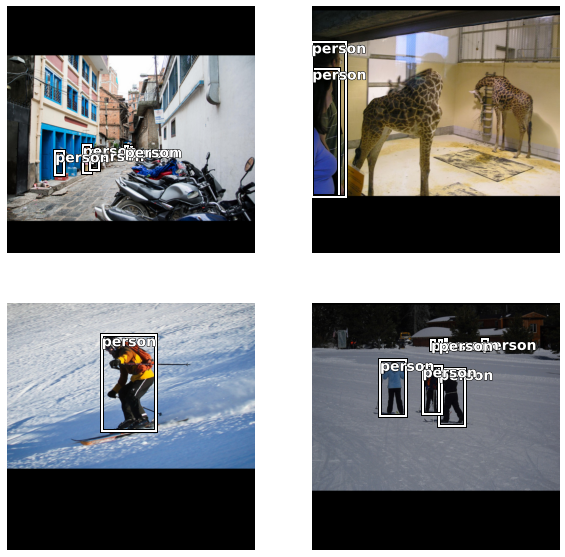

In [ ]:
dls.show_batch(figsize=(10,10))

In [ ]:
sgd_90 = partial(SGD, mom=0.9)

In [ ]:
learn = efficientdet_learner(dls, efficientdet_d0, 
                             opt_func=sgd_90, lr=0.005, wd=0.0005, train_bn=False,
                             metrics=[mAP_at_IoU50])
learn.freeze()

Downloading: "https://github.com/zylo117/Yet-Another-Efficient-Pytorch/releases/download/1.0/efficientdet-d0.pth" to /root/.cache/torch/hub/checkpoints/efficientdet-d0.pth


SuggestedLRs(valley=0.0002290867705596611)

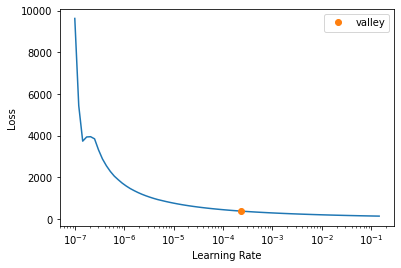

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-04)

epoch,train_loss,valid_loss,mAP@IoU>0.5,time
0,3.730101,1.968773,0.537900,00:48
1,2.186584,1.821930,0.618715,00:49
2,1.898224,1.704035,0.654038,00:49
3,1.942195,1.717927,0.671782,00:49
4,2.152703,1.642953,0.676465,00:48


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, 1e-04)

epoch,train_loss,valid_loss,mAP@IoU>0.5,time
0,1.820708,1.573239,0.692665,01:18
1,1.678120,1.388186,0.704161,01:18
2,1.538839,1.403449,0.702665,01:19
